# New York City Subway Ridership

In [4]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
# suppress warning
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf

In [52]:
#Daily entry and exit data of subway stations in NYC
#edit file location
SubwayData2020 = pd.read_csv('.../turnstile_daily_counts_2020/body.csv')
SubwayData2019 = pd.read_csv('.../turnstile_daily_counts_2019/body.csv')
SubwayData2021 = pd.read_csv('.../turnstile_daily_counts_2021/body.csv')
SubwayData = pd.concat([SubwayData2019,SubwayData2020,SubwayData2021])
SubwayData['date'] = pd.to_datetime(SubwayData['date'])
SubwayData.head()

,stop_name,daytime_routes,division,line,borough,structure,gtfs_longitude,gtfs_latitude,complex_id,date,entries,exits
0,Astoria - Ditmars Blvd,N W,BMT,Astoria,Q,Elevated,-73.912034,40.775036,1,2019-01-01,5896.0,5319.0
1,Astoria - Ditmars Blvd,N W,BMT,Astoria,Q,Elevated,-73.912034,40.775036,1,2019-01-02,14472.0,9702.0
2,Astoria - Ditmars Blvd,N W,BMT,Astoria,Q,Elevated,-73.912034,40.775036,1,2019-01-03,15674.0,12234.0
3,Astoria - Ditmars Blvd,N W,BMT,Astoria,Q,Elevated,-73.912034,40.775036,1,2019-01-04,15534.0,13489.0
4,Astoria - Ditmars Blvd,N W,BMT,Astoria,Q,Elevated,-73.912034,40.775036,1,2019-01-05,7813.0,8937.0


In [53]:
SubwayData.describe() #Data seems reasonable and clean

,gtfs_longitude,gtfs_latitude,entries,exits
count,350043.000000,350043.000000,350258.000000,350258.000000
mean,-73.936251,40.729624,7271.893065,6107.903423
std,0.060332,0.078831,13527.737279,12215.323937
min,-74.167920,40.576127,0.000000,0.000000
25%,-73.981824,40.675377,1462.000000,1183.000000
50%,-73.947649,40.721691,3404.000000,2708.000000
75%,-73.898583,40.785672,7640.000000,6010.000000
max,-73.755405,40.903125,223455.000000,203291.000000


In [54]:
# aggregate subway station datapoints to total entries & total exists per day
SubwayDailyData = SubwayData.groupby(['date']).agg({'entries':'sum','exits':'sum'}).reset_index()
SubwayDailyData.head()

,date,entries,exits
0,2019-01-01,2428220.0,2086121.0
1,2019-01-02,5138710.0,3973106.0
2,2019-01-03,5595341.0,4334046.0
3,2019-01-04,5549644.0,4313218.0
4,2019-01-05,2972517.0,2502875.0


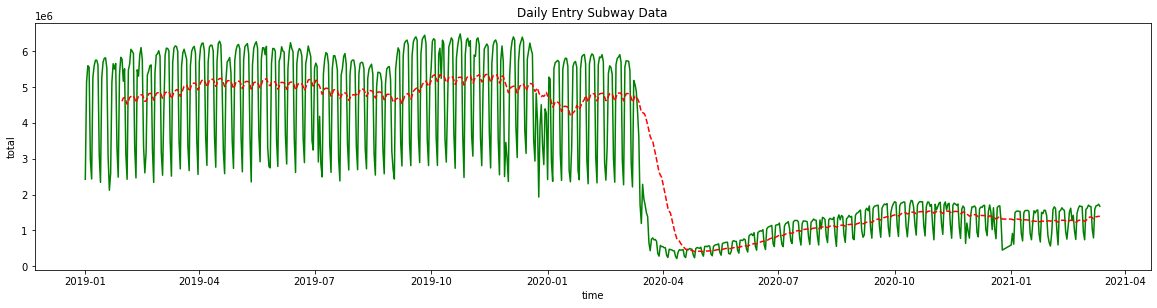

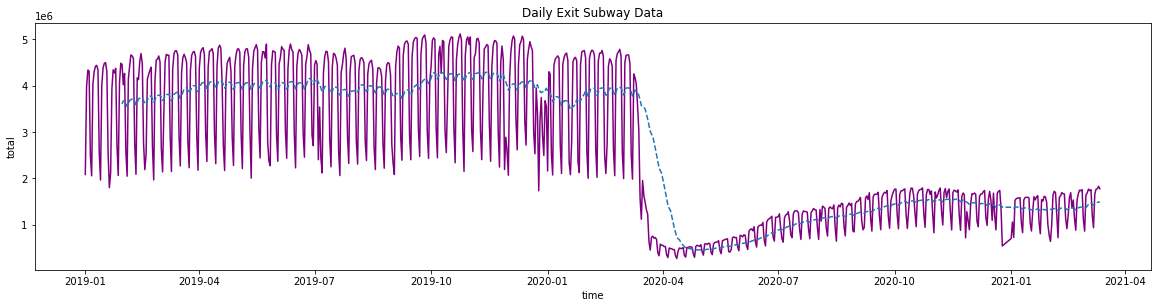

In [55]:
# plot the daily enties and exits
# the '--' line is 30-day moving average
xTime = SubwayDailyData['date']
yEntries = SubwayDailyData['entries']
yExits = SubwayDailyData['exits']
plt.figure(figsize = (20,10))
plt.subplot(211)
plt.title('Daily Entry Subway Data')
plt.xlabel('time')
plt.ylabel('total')
entry_data_line = plt.plot(xTime,yEntries, label = 'Entries', color = 'green')
exit_mean_line = plt.plot(xTime,yEntries.rolling(window = 30).mean(), label='Entries Mean', linestyle='--',color='red')


plt.figure(figsize = (20,10))
plt.subplot(212)
plt.title('Daily Exit Subway Data')
plt.xlabel('time')
plt.ylabel('total')
exit_data_line = plt.plot(xTime,yExits, label = 'Exits', color = 'purple')
exit_mean_line = plt.plot(xTime,yExits.rolling(window = 30).mean(), label='Exits Mean', linestyle='--')
plt.show()

# London Tube Ridership

In [56]:
LondonData2020 = pd.read_csv('.../FOI 1760 2021/FOI 1760-2021.csv')
TubeData2020 = LondonData2020.loc[(LondonData2020['Transport Mode']=='Rail')]
TubeData2020 = TubeData2020.loc[(TubeData2020['Transaction Type'] == 'Exit')|(TubeData2020['Transaction Type'] == 'Entry')]
#TubeData2020['Travel Date'] = pd.to_datetime(TubeData2020['Travel Date'])
TubeData2020['Travel Date'] = pd.to_datetime(TubeData2020['Travel Date'], format='%d/%m/%Y %H:%M')

In [57]:
TubeData2020.head()
#PVALs = Passenger Validator (bi-directional card readers on a standalone 
#plinths, rather than directional gates, most common at DLR, Tram and River 
#services); contactless taps on PVALs do not get recorded as entries or 
#exits, due to the way journeys are constructed in the ticketing system 
#back office.

#IVALs – Intermediate Validation – some taps at some stations get recorded 
#as IVAL instead of entries and exits; we are unable to determine in the 
#data we have available whether these constituted an entry or an exit at 
#the time.
TubeData2020.loc[(TubeData2020['Count of Taps'] > 50000)&(TubeData2020['Travel Date'] > '2020-03-14')][80:130].sort_values(by='Travel Date')

,Travel Location Name,Travel Location No,Transport Mode,Travel Date,Transaction Type,Count of Taps


In [58]:
# aggregate subway station datapoints to total entries & total exists per day
#TubeDataDaily = pd.DataFrame(data={'date'})
TubeDataDailyEntries = TubeData2020.loc[TubeData2020['Transaction Type'] == 'Entry'].groupby(['Travel Date'])\
                                            .agg({'Count of Taps':'sum'}).reset_index()\
                                            .rename(columns = {'Count of Taps':'Total Entries'})
TubeDataDailyExits = TubeData2020.loc[TubeData2020['Transaction Type'] == 'Exit'].groupby(['Travel Date'])\
                                                .agg({'Count of Taps':'sum'}).reset_index()\
                                                .rename(columns = {'Count of Taps':'Total Exits'})

TubeDataDaily = TubeDataDailyEntries.merge(TubeDataDailyExits,on='Travel Date')


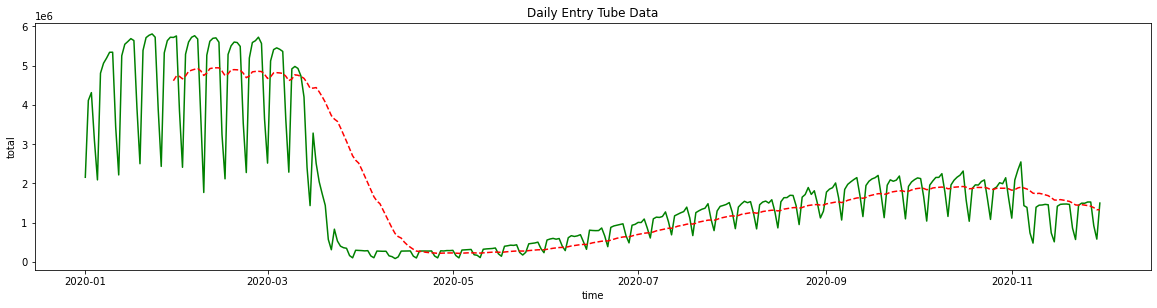

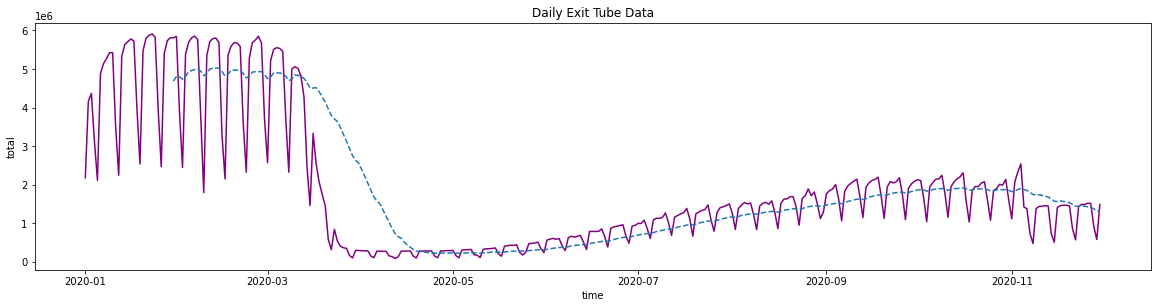

In [59]:
# plot the daily enties and exits
# the '--' line is 30-day moving average
xTime = TubeDataDaily['Travel Date']
yEntries = TubeDataDaily['Total Entries']
yExits = TubeDataDaily['Total Exits']
plt.figure(figsize = (20,10))
plt.subplot(211)
plt.title('Daily Entry Tube Data')
plt.xlabel('time')
plt.ylabel('total')
entry_data_line = plt.plot(xTime,yEntries, label = 'Entries', color = 'green')
exit_mean_line = plt.plot(xTime,yEntries.rolling(window = 30).mean(), label='Entries Mean', linestyle='--',color='red')


plt.figure(figsize = (20,10))
plt.subplot(212)
plt.title('Daily Exit Tube Data')
plt.xlabel('time')
plt.ylabel('total')
exit_data_line = plt.plot(xTime,yExits, label = 'Exits', color = 'purple')
exit_mean_line = plt.plot(xTime,yExits.rolling(window = 30).mean(), label='Exits Mean', linestyle='--')
plt.show()